# Trouble with cftime when using NetCDFtoZarrSequentialRecipe

In [1]:
import pandas as pd
import xarray as xr

# the versions are fine for cftime:
import zarr
import cftime
xr.__version__, zarr.__version__, cftime.__version__, pd.__version__

('0.16.2', '2.6.1', '1.3.1', '1.2.1')

In [2]:
input_urls = ['http://esgf-data.ucar.edu/thredds/fileServer/esg_dataroot/CMIP6/CMIP/NCAR/CESM2/historical/r8i1p1f1/Amon/pr/gn/v20190401/pr_Amon_CESM2_historical_r8i1p1f1_gn_185001-189912.nc',
              'http://esgf-data.ucar.edu/thredds/fileServer/esg_dataroot/CMIP6/CMIP/NCAR/CESM2/historical/r8i1p1f1/Amon/pr/gn/v20190401/pr_Amon_CESM2_historical_r8i1p1f1_gn_190001-194912.nc']

In [3]:
#input_urls = input_urls[:1]   This experiment works properly

In [4]:
# Look at the first file from the dataset, using the OPeNDAP url:
url_http = input_urls[0]
url_dods = url_http.replace('fileServer','dodsC')
ds = xr.open_dataset(url_dods)
ntimes = len(ds.time)
print(f"number of time slices in first file = {ntimes}")

number of time slices in first file = 600


/usr/local/python/anaconda3/envs/pangeo-forge/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


In [5]:
# verify all is fine with the dataset and with my version of xarray, cftime, etc
#print(f"first time = {ds.time[0]}")

#zbdir = 'zarr-tmp'
#print('\nsave zarr dataset')
#ds.to_zarr(zbdir, consolidated=True, mode='w')
#ds2 = xr.open_zarr(zbdir)
#print(f"first time = {ds2.time[0]}")

In [6]:
import tempfile
from fsspec.implementations.local import LocalFileSystem
from pangeo_forge.storage import FSSpecTarget, CacheFSSpecTarget

fs_local = LocalFileSystem()

cache_dir = tempfile.TemporaryDirectory()
cache_target = CacheFSSpecTarget(fs_local, cache_dir.name)
print(cache_target)

target_dir = tempfile.TemporaryDirectory()
target = FSSpecTarget(fs_local, target_dir.name)
print(target)

CacheFSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x7f5a504cfd90>, root_path='/tmp/tmpo9fztuh6')
FSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x7f5a504cfd90>, root_path='/tmp/tmpuh4bgxzu')


In [7]:
# Choose a Recipe:
from pangeo_forge.recipe import NetCDFtoZarrSequentialRecipe

recipe = NetCDFtoZarrSequentialRecipe(
        input_urls=input_urls,
        sequence_dim="time",
        xarray_open_kwargs={'use_cftime':True},
        #xarray_open_kwargs={'decode_times':False},  # this makes a problem with 365_day calendar in recipe.prepare_target()
        inputs_per_chunk=1,
        nitems_per_input=ntimes
)

recipe.input_cache = cache_target
recipe.target = target

for input_file in recipe.inputs_for_chunk(0):
    recipe.cache_input(input_file)

recipe.prepare_target()

/usr/local/python/anaconda3/envs/pangeo-forge/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


In [8]:
ds_chunk = recipe.open_chunk(0)   
print(f'Total chunk size: {ds_chunk.nbytes / 1e6} MB')  
#zgroup = zarr.open(target_dir.name)
#print(zgroup.tree())

/usr/local/python/anaconda3/envs/pangeo-forge/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


Total chunk size: 137.33664 MB


In [9]:
#from cftime import DatetimeNoLeap
# store first chunk
recipe.store_chunk(0)

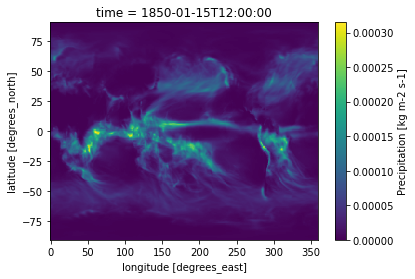

In [10]:
# check first chunk
ds = xr.open_zarr(target_dir.name)
ds['pr'][0].plot()

In [11]:
# Now lets try the second chunk:

for input_file in recipe.inputs_for_chunk(1):
    print(input_file)
    recipe.cache_input(input_file)

ds_chunk = recipe.open_chunk(1)  

recipe.store_chunk(1)

zgroup = zarr.open(target_dir.name)
zgroup['pr'].info

http://esgf-data.ucar.edu/thredds/fileServer/esg_dataroot/CMIP6/CMIP/NCAR/CESM2/historical/r8i1p1f1/Amon/pr/gn/v20190401/pr_Amon_CESM2_historical_r8i1p1f1_gn_190001-194912.nc


/usr/local/python/anaconda3/envs/pangeo-forge/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


Name,/pr
Type,zarr.core.Array
Data type,float32
Shape,"(1200, 192, 288)"
Chunk shape,"(600, 192, 288)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,265420800 (253.1M)
No. bytes stored,217145754 (207.1M)


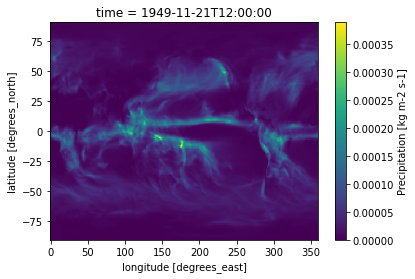

In [12]:
ds = xr.open_zarr(target_dir.name)
ds['pr'][-1].plot()

In [13]:
recipe.finalize_target()

NHN: Consolidating Zarr metadata
